In [1]:
# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 1
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plotting settings
import matplotlib.pyplot as plt
size=35
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

Autosaving every 1 seconds


# Accessing files

Every file under any folder in ./data is parsed and put into dictionaries that group videos of the same source.
Videos of the same source are considered videos coming from the same Subject, same Session, same OD/OS, same (x, y),
same type (Confocal, OA790, OA850).

The parsing is case insensitive with the following rules:

**unmarked videos**:
must not contain 'mask' or '_marked'

**marked videos**:
Must end with '_marked.\<<file_extension\>>'

**standard deviation images**:
Must end with
'_std.\<<file_extension\>>'

**vessel mask images**: 
Must end with
'_vessel_mask.\<<file_extension\>>'

**channel type**:
must contain one of 'OA790', 'OA850', 'Confocal' (case insensitive)

### Example to using dictionaries that relate video of the OA790 channel that have marked videos 
(useful for training and training)

In [2]:
from sharedvariables import get_video_sessions
from os.path import basename

# video_type must be one of 'oa790', 'oa850', 'confocal'
video_sessions = get_video_sessions(should_have_marked_video=True)
for session in video_sessions:
        assert session.has_marked_video
        print('-----------------------')
        print('Video file:', basename(session.video_file))
        print('Does video have a corresponding marked video?:', session.has_marked_video)
        print('Channel type:', session.type)
        print('Subject number:', session.subject_number)
        print('Session number:', session.session_number)
        print('Marked Video OA790:', basename(session.marked_video_oa790_file))
#         print('Marked Video OA850:', basename(session.marked_video_oa850_file)))
        print('Std dev image confocal:', basename(session.std_image_confocal_file))
#         print('Std dev image OA790:', basename(session.std_image_oa790_file)))
        print('Std dev image OA850:', basename(session.std_image_oa850_file))
#         print('Vessel mask OA790:', basename(session.vessel_mask_oa790_file)))
        print('Vessel mask OA850:', basename(session.vessel_mask_oa850_file))
        print('Vessel mask confocal:', basename(session.vessel_mask_confocal_file))
        print('Cell position csv files:', *[basename(f) for f in session.cell_position_csv_files], sep='\n')
        print()

-----------------------
Video file: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped.avi
Does video have a corresponding marked video?: True
Channel type: oa790
Subject number: 25
Session number: 298
Marked Video OA790: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_marked.avi
Std dev image confocal: Subject25_Session298_OD_(-2,0)_1.03x1_1642_Confocal_dewarped1_extract_reg_std.tif
Std dev image OA850: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA850nm_dewarped1_extract_reg_std.tif
Vessel mask OA850: Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA850nm_vessel_mask.JPEG
Vessel mask confocal: Subject25_Session298_OD_(-2,0)_1.03x1_1642_Confocal_vessel_mask.jpg
Cell position csv files:
Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_cords.csv

-----------------------
Video file: Subject3_Session217_OS_(2,0)_1x1_988_OA790nm_dewarped1_extract_reg_cropped.avi
Does video have a corresponding marked 

# Reading frames from videos

You can get access to the frames of the video session.

In [3]:
session = video_sessions[0]
print(session.frames_oa790.shape)
print(session.frames_oa850.shape)
print(session.marked_frames_oa790.shape)

(43, 576, 564)
(43, 576, 564)
(43, 576, 564)


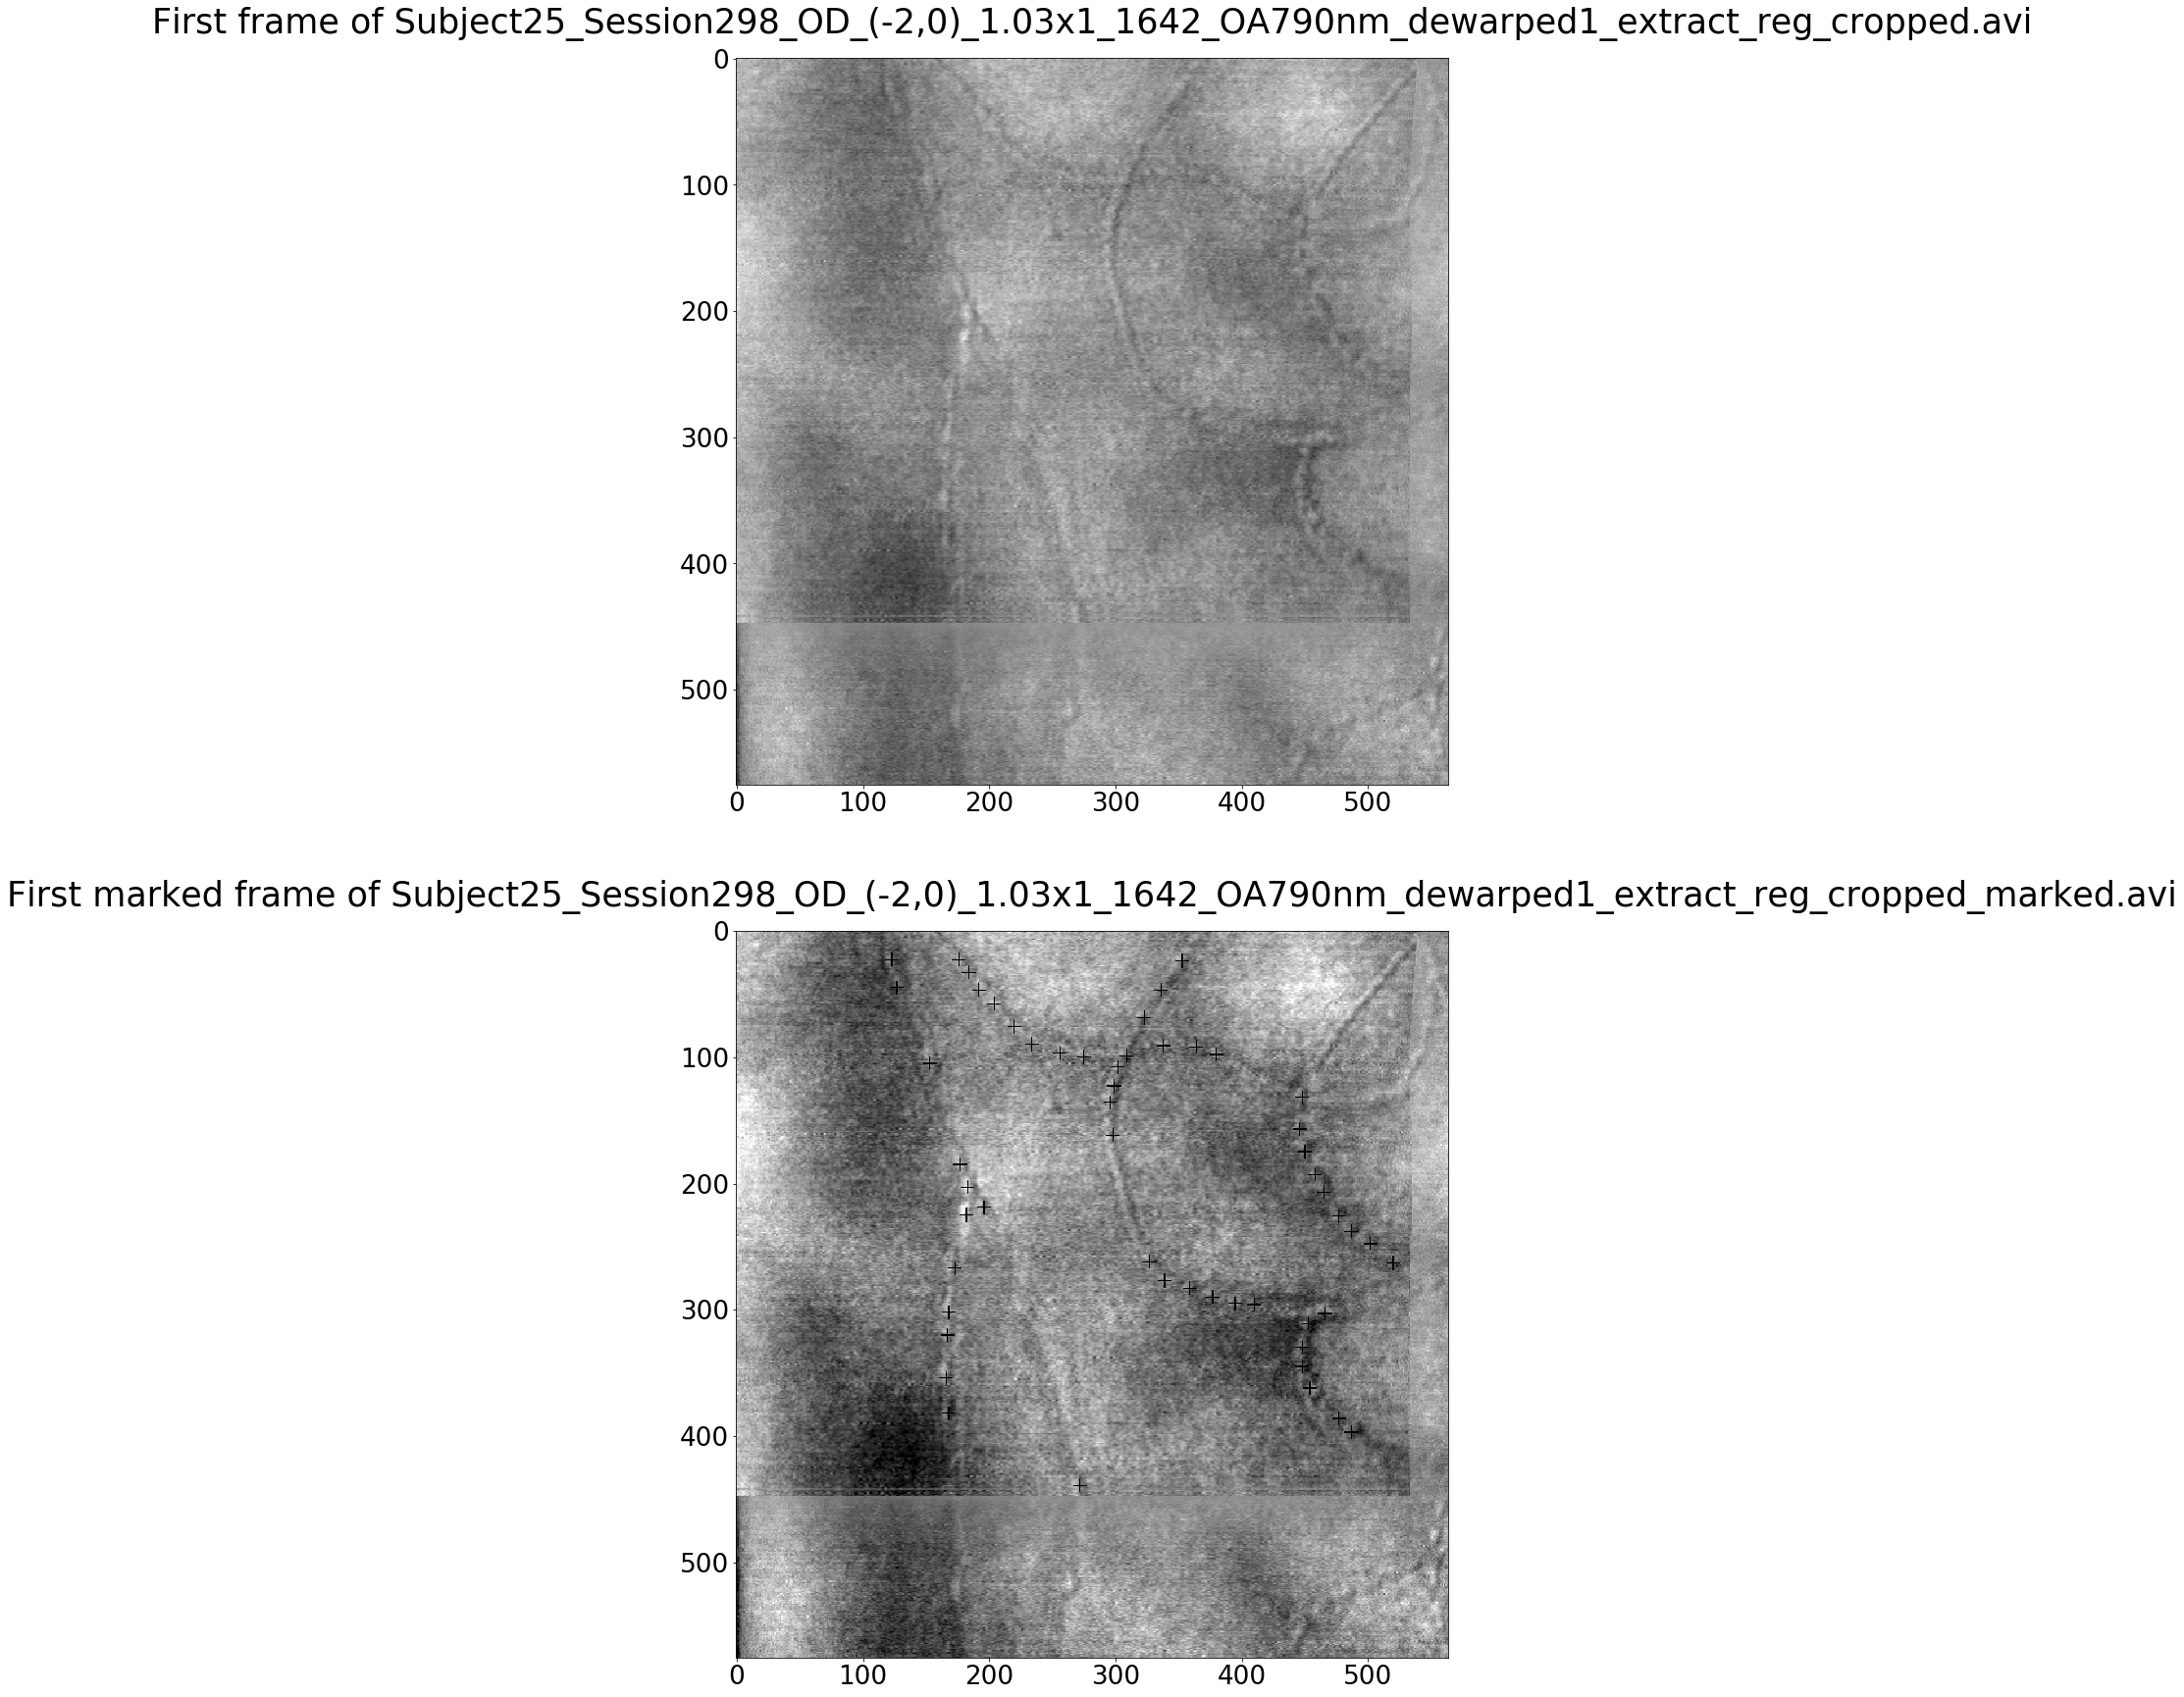

In [4]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(2, 1, figsize=(30, 30))
axes[0].imshow(session.frames_oa790[0], cmap='gray')
axes[0].set_title(f"First frame of {basename(session.video_oa790_file)}")
    
axes[1].imshow(session.marked_frames_oa790[0], cmap='gray')
axes[1].set_title(f"First marked frame of {basename(session.marked_video_oa790_file)}")
pass

.\data\registered-videos\marked\Subject25_Session298_OD_(-2,0)_1.03x1_1642_OA790nm_dewarped1_extract_reg_cropped_cords.csv


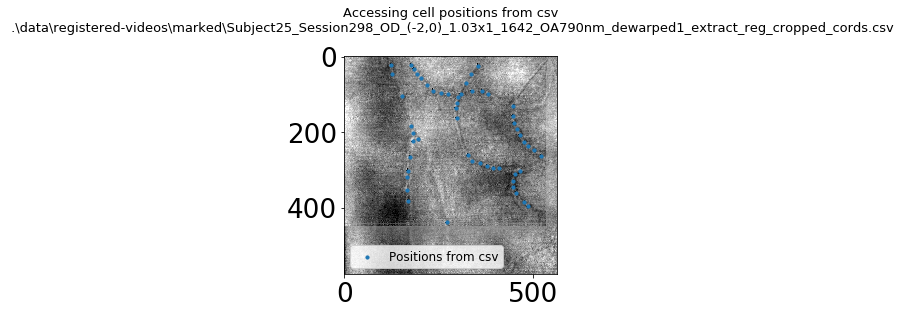

In [5]:
# Notice how python is 0-indexed while the csv file is 1 indexed, hence frame_idx is 1 instead of 0
print(session.cell_position_csv_files[0])
plt.imshow(session.marked_frames_oa790[0], cmap='gray')
plt.scatter(session.cell_positions[1][..., 0], session.cell_positions[1][..., 1], s=10, label='Positions from csv')
plt.title(f'Accessing cell positions from csv\n {session.cell_position_csv_files[0]}', fontsize=13)
plt.legend()
pass

### How to extract patches

In [6]:
session.marked_frames_oa790[0].shape

(576, 564)

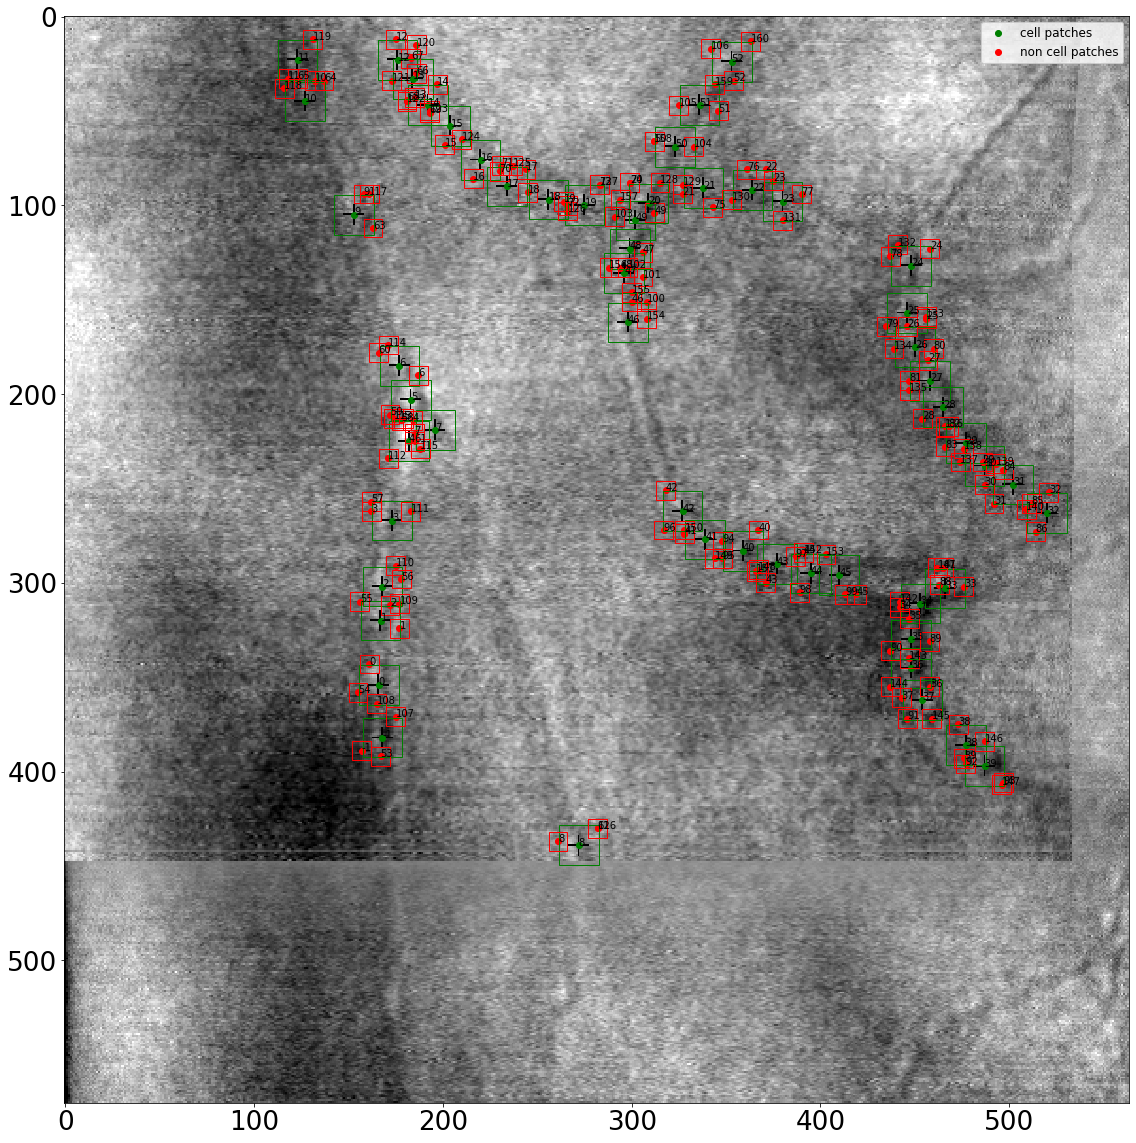

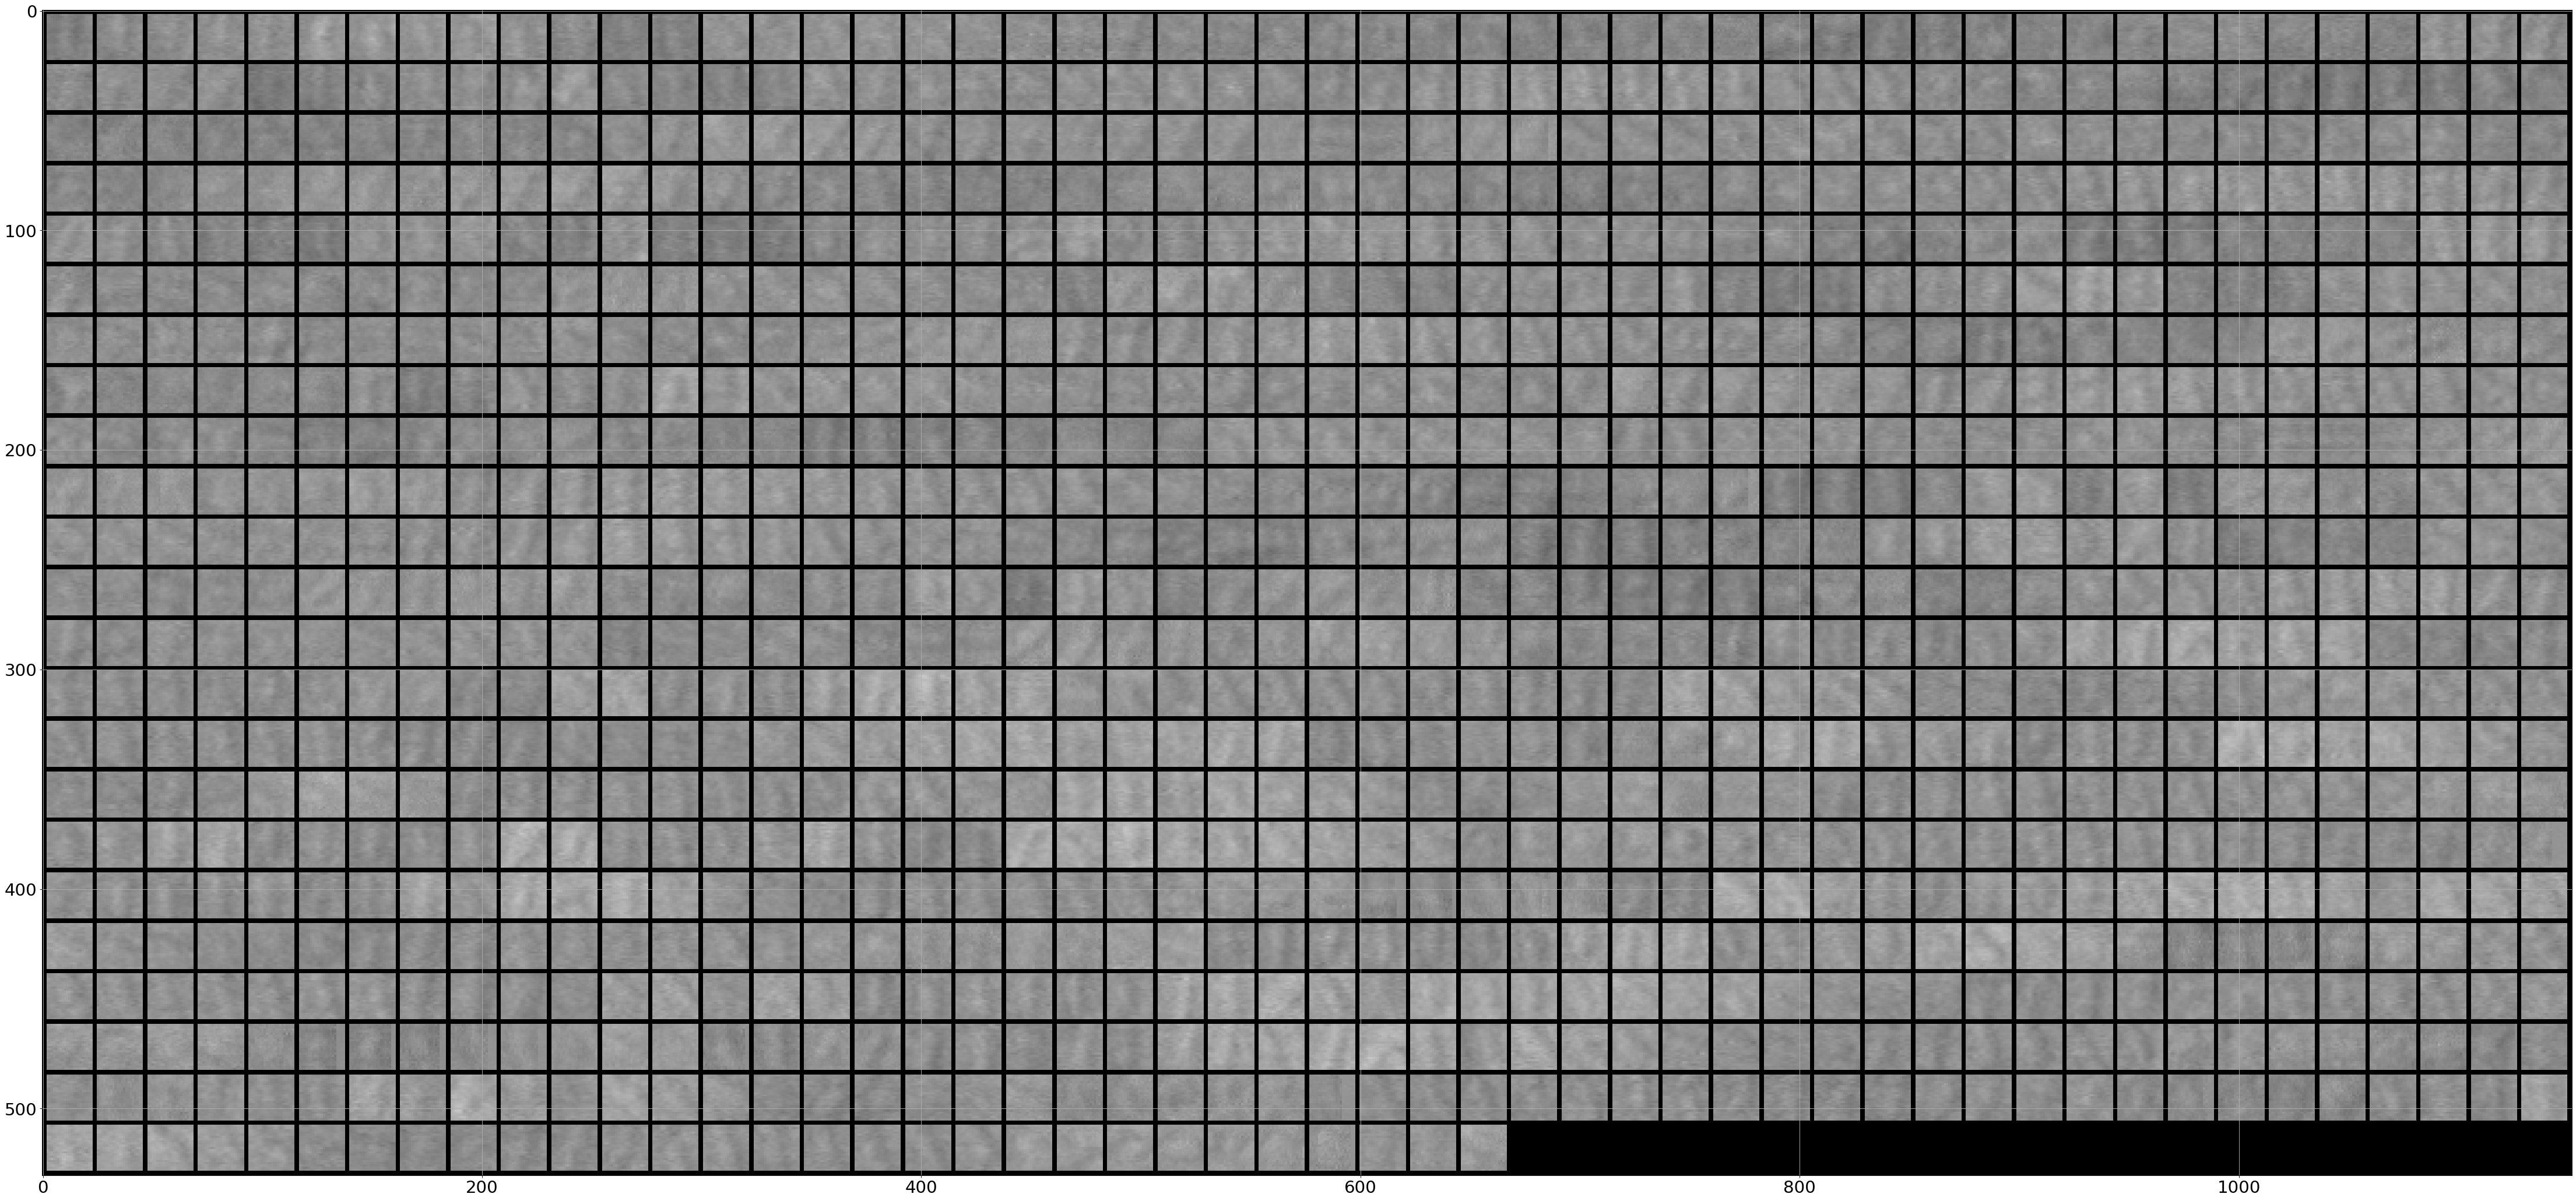

In [73]:
from patchextraction import SessionPatchExtractor
from plotutils import plot_patch_rois_at_positions, plot_images_as_grid
from generate_datasets import get_random_point_on_rectangle
import numpy as np

patch_extractor = SessionPatchExtractor(session, patch_size=21)
cell_patches_patch_extractor = patch_extractor.cell_patches_oa790

_, ax = plt.subplots(figsize=(20, 20))
ax.imshow(session.marked_frames_oa790[0], cmap='gray')

cxs, cys = session.cell_positions[1][:, 0], session.cell_positions[1][:, 1]
rxs, rys = get_random_point_on_rectangle(cxs, cys, rect_size=21, n_points_per_rect=3)

plot_patch_rois_at_positions(session.cell_positions[1], patch_size=21, ax=ax, edgecolor='g', pointcolor='g', label='cell patches')
plot_patch_rois_at_positions(np.array([rxs, rys]).T, patch_size=10, ax=ax, pointcolor='r', label='non cell patches')
plt.legend()

plot_images_as_grid(cell_patches_patch_extractor)

### How to get standard deviation image and vessel masks

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(50, 10))

axes[0].imshow(session.std_image_oa850)
axes[0].set_title('Std image oa850', fontsize=10)

axes[1].imshow(session.std_image_confocal)
axes[1].set_title('Std image confocal', fontsize=10)

axes[2].imshow(session.vessel_mask_oa850)
axes[2].set_title('Vessel mask oa850', fontsize=10)

axes[3].imshow(session.vessel_mask_confocal)
axes[3].set_title('Vessel mask confocal', fontsize=10)
pass